## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [30]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import signal as sg
import utils
import os
%matplotlib inline

In [31]:
image = utils.load_image("./camera_cal/calibration1.jpg")

In [46]:
height

1280

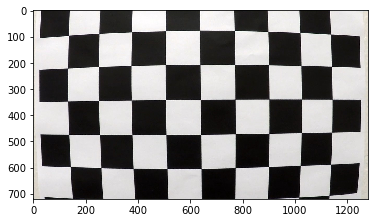

In [3]:
plt.imshow(image)
plt.show()

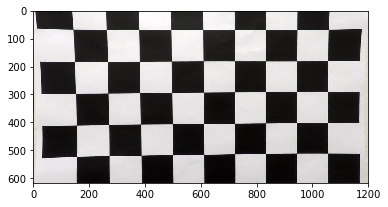

In [4]:
plt.imshow(utils.undistort(image))
plt.show()

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. 

I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

In [5]:
img = utils.load_image("./test_images/test5.jpg")

In [6]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
rgb = img
yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

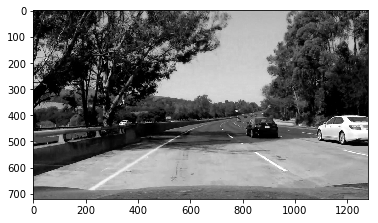

In [7]:
plt.imshow(hsv[:,:,2],cmap='gray')

In [5]:
def yellowandwhite(hsv_image):
    
    masks = []
    
    low_white,  high_white =  np.array([0, 0, 205]),  np.array([255, 40, 255])
    low_yellow, high_yellow = np.array([20, 40, 100]),np.array([70, 255, 255])
    
    white = cv2.inRange(hsv_image, low_white, high_white)
    masks.append(white)
    
    yellow = cv2.inRange(hsv_image, low_yellow, high_yellow)
    masks.append(yellow)
    
    return cv2.add(*masks)

In [6]:
plt.imshow(yellowandwhite(hsv), cmap='gray')
plt.show()

NameError: name 'plt' is not defined

### Binarify function.

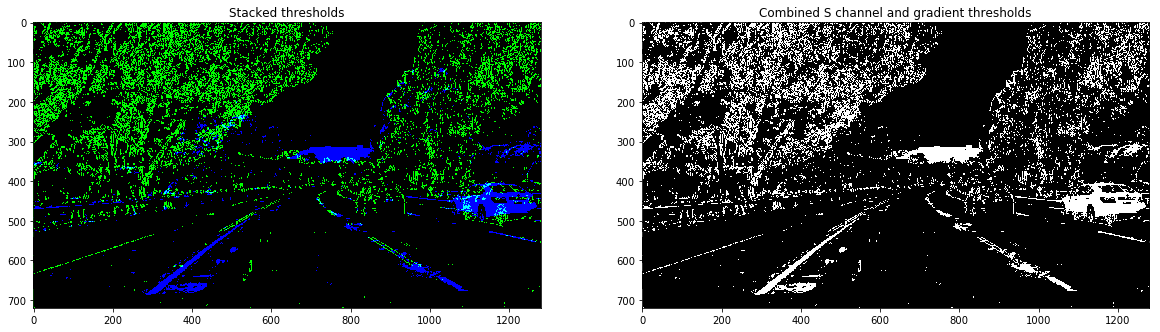

In [10]:
image = utils.load_image("./test_images/test1.jpg")
#Save copy of HLS colorspace and then save a copy of the 3rd layer, which is saturation.
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
yaw = yellowandwhite(hsv)

#Save a copy of a converted to grayscale image.
gray = hls[:,:,1]

# Sobel is a filter for left edges that is convolved over the image. 
# Then we take the absolute value to retreive the right edges.
# Finally, we scale this to between 0-255
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobelx)
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshholding. Create a blank image or zeroes. 
# Changing to 1 if the pixel value was within the threshold values.
thresh_min, thresh_max = (20, 100)
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshholding. 
yawbinary = np.zeros_like(yaw)
yawbinary[(yaw >= 20)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, yawbinary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(yawbinary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
plt.savefig('binary')

### Bird's eye transform

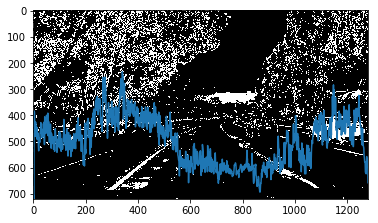

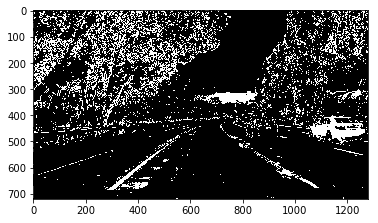

In [11]:
histogram = 720 - np.sum(combined_binary, axis=0)*2
plt.plot(histogram)
plt.imshow(combined_binary, cmap='gray') 
plt.show()
plt.imshow(combined_binary, cmap='gray') 
plt.show()

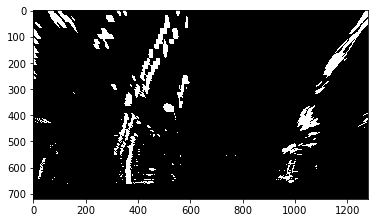

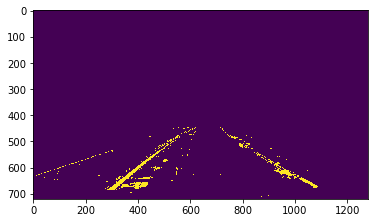

In [12]:
image_width, image_height = combined_binary.shape[1], combined_binary.shape[0]


#src is a list of starting locations, dst is where those points finish at.
#In this case, we're squeezing the lane near us to match the points in the distance, making them parallel. 
src = np.float32 ([
        [220, 650],
        [350, 577],
        [828, 577],
        [920, 650]
    ])

dst = np.float32 ([
        [260, 650],
        [260, 610],
        [880, 610],
        [880, 650]
    ])


M = cv2.getPerspectiveTransform(src, dst) 
Minv = cv2.getPerspectiveTransform(dst, src)

binary_warped = cv2.warpPerspective(combined_binary, M, (image_width, image_height)) 
plt.imshow(binary_warped, cmap='gray') 
plt.show()

img_inv = cv2.warpPerspective(binary_warped, Minv, (image_width, image_height))
plt.imshow(img_inv) 
plt.show()

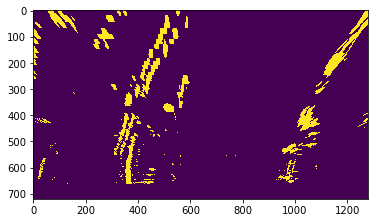

In [13]:
plt.imshow(binary_warped)
plt.show()

### Lane search, sliding window

In [14]:
binary_warped.shape

(720, 1280)

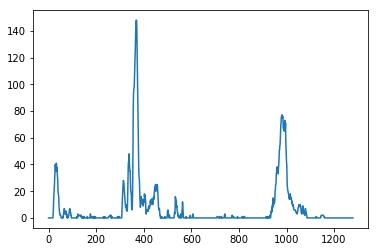

In [15]:
image_height, image_width  = binary_warped.shape
midpoint = np.int(image_width/2)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(5*image_height/7):,:], axis=0)
plt.plot(histogram)

leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [16]:
leftx_base, rightx_base

(368, 980)

In [17]:
num_windows = 10
window_height = image_height/num_windows

#number of pixels to the left and right of the center spike. ie window_width/2
window_offset = 50

In [18]:
def convert_box(coord1, coord2):
    
    if coord2[:]<coord1[:]:
        temp = coord1
        coord1 = coord2
        coord2 = temp
    
    height = coord2[0]-coord1[0]
    width = coord2[1]-coord1[1]
    return (coord1[0], coord1[1]), height, width

In [19]:
leftx, rightx = leftx_base, rightx_base
leftleft, leftright, rightleft, rightright = leftx-window_offset, leftx+window_offset, rightx-window_offset, rightx+window_offset
lane_lines = np.zeros_like(binary_warped)
boxs = []

for y_high in range(int(num_windows*window_height), 0, int(-window_height)):
    y_low = int(y_high-window_height)
    
    lhistogram = np.sum(binary_warped[y_low:y_high,leftleft:leftright], axis=0)
    rhistogram = np.sum(binary_warped[y_low:y_high,rightleft:rightright], axis=0)
    
    if np.max(lhistogram):
        leftx = np.argmax(lhistogram)+leftleft
    if np.max(rhistogram):
        rightx = np.argmax(rhistogram)+rightleft
    
    leftleft, leftright, rightleft, rightright = leftx-window_offset, leftx+window_offset, rightx-window_offset, rightx+window_offset
    
    boxs += convert_box([leftleft,y_low],[leftright,y_high]), convert_box([rightleft,y_low],[rightright,y_high])
    
    lane_lines[y_low:y_high, leftleft: leftright] =  binary_warped[y_low:y_high, leftleft:leftright] 
    lane_lines[y_low:y_high, rightleft:rightright] = binary_warped[y_low:y_high, rightleft:rightright] 


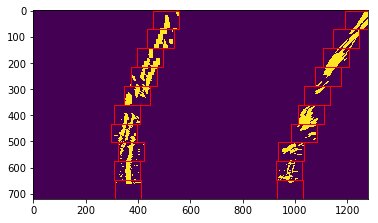

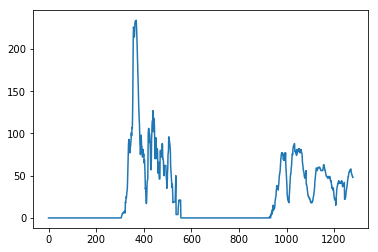

In [20]:

fig,ax = plt.subplots(1)
ax.imshow(lane_lines)

for box in boxs:
    rect = patches.Rectangle(box[0],box[1],box[2],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

histogram = np.sum(lane_lines, axis=0)
plt.plot(histogram)
plt.show()


### Fitting the lane lines to a curve

In [2]:
y, x = np.nonzero(lane_lines)

NameError: name 'np' is not defined

In [3]:
y, x = np.nonzero(lane_lines)
plt.scatter(x, 720-y)

NameError: name 'np' is not defined

In [23]:
leftx, lefty = x[x<800], 720-y[x<800]
rightx, righty = x[x>800], 720-y[x>800]
rightx

array([1270, 1271, 1272, ..., 1020, 1007, 1008])

In [24]:
left_fit = np.polyfit(lefty, leftx, 2)
left_fit

array([  6.04324737e-04,  -1.72346768e-01,   3.71124945e+02])

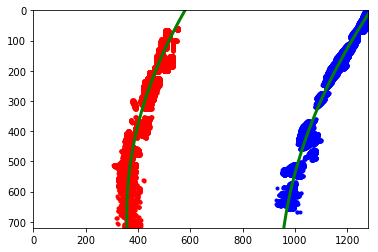

In [25]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
y, x = np.nonzero(lane_lines)
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)

leftx, lefty = x[x<750], 720-y[x<750]
rightx, righty = x[x>750], y[x>750]

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(lefty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]

right_fit = np.polyfit(righty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [26]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1024.77125953 1245.19073201


This involves measuring how long and wide the section of lane is that we're projecting in our warped image.

We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. 

Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

So here's a way to repeat the calculation of radius of curvature after correcting for scale in x and y:

In [4]:
# Define conversions in x and y from pixels space to meters
xm_per_pix = 3.7 / 652      # meters per pixel in x dimension (lane width in US = 3.7 m)
ym_per_pix = 3.0 / 80       # meters per pixel in y dimension (dashed marker length in US = 3.0 m)
cam_pos_x = 1280 / 2.       # camera x-position in pixel (center of image)

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

NameError: name 'np' is not defined

## And so on and so forth...

The goals / steps of this project are the following:

* (done) Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* (done) Apply a distortion correction to raw images.
* (improve) Use color transforms, gradients, etc., to create a thresholded binary image.
* (done) Apply a perspective transform to rectify binary image ("birds-eye view").
* (done) Detect lane pixels and fit to find the lane boundary.
* (improve) Determine the curvature of the lane and vehicle position with respect to center.
* (done) Warp the detected lane boundaries back onto the original image.
* (improve) Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


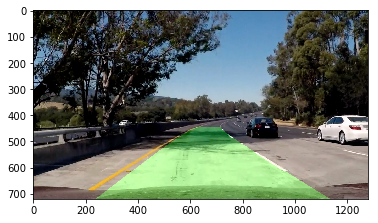

In [28]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(lane_lines).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.savefig('final.jpg')

The Goal of this Project

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in the project repository.
The Writeup

The writeup will be the primary output you submit (along with your code of course).

Within the project repository, there is a writeup template that you can use as a starting point for your project writeup.

A great writeup should include the rubric points as well as your description of how you addressed each point. You should include a detailed description of the code used in each step (with line-number references and code snippets where appropriate) and links to other supporting documents or external references. You should also include images in your writeup to illustrate how your code works.

All that said, please be concise! We're not looking for you to write a book, just a brief description of how you passed each rubric point, and references to the relevant code :)

You are not required to use Markdown for your writeup. If you use another method, please just submit a PDF of your writeup.
The Code

Your code should stand on its own as readable material. Explain in code comments, as well as in your writeup, how your code works and why you wrote it that way.

Make it easy for a reviewer to understand your code.

You are more than welcome to use code from the lesson. But if you copy something explain how it works and why you used it.
What It Takes to Pass

Read the project rubric for details on the requirements for a passing submission.

Your writeup should include each rubric point and your description of how you addressed that point in your submission. The project repo provides an example template for your writeup.

There is no starter code provided, but you are welcome to use code from the lesson and quizzes as you like. You may complete the project in a Jupyter notebook, but it's not required. Feel free to build it as a standalone project.

To help the reviewer evaluate your project, please save example images from each stage of your pipeline to the output_images folder and provide in your writeup a description of each image. Please also save your output video and include it with your submission.
Evaluation

Once you have completed your project, double check the Project Rubric to make sure you have addressed all the rubric points. Your project will be evaluated by a Udacity reviewer according to that same rubric.

Your project must "meet specifications" in each category in order for your submission to pass. If you are happy with your submission, then you are ready to submit! If you see room for improvement in any category in which you do not meet specifications, keep working!
Submission
What to Include

Include a zipped file with your:

    writeup
    code (or a Jupyter notebook)
    example output images
    output video

Alternatively, you may submit a link to your GitHub repo for the project.

In either case, remember to include example images for each stage of your pipeline and your final output video in your submission.
Ready to Submit?

Click on the "Submit Project" button and follow the instructions!
Using GitHub and Creating Effective READMEs

If you are unfamiliar with GitHub , Udacity has a brief GitHub tutorial to get you started. Udacity also provides a more detailed free course on git and GitHub.

To learn about REAMDE files and Markdown, Udacity provides a free course on READMEs, as well.

GitHub also provides a tutorial about creating Markdown files.
